<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNSPV/notebooky/keras_2020/cv07_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7. cvičenie - Fine-tuning a vizualizácia

Na dnešnom cvičení si prejdeme metódu tzv. fine-tuningu, ktorá spadá pod tzv. metódy transfer learningu. Túto úlohu vyskúšate na Google Cloude. V druhej časti cvičenia si skúsime zobraziť ktoré časti obrázku sú pre sieť dôležité na klasifikáciu.

## 1. Úloha

Túto úlohu vypracujte na cloude. Pripraviť si ju môžete u seba, alebo v Colabe. Skúste si ju však spustiť aj na cloude.

V tejto úlohe budeme trénovať sieť s predtrénovanými váhami tzv. fine-tuning alebo transfer learning. Predtrénované modely prevezmeme z [keras applications](https://keras.io/applications/) na datasete cats vs. dogs, ktorý stiahnete napríklad tu:

```
https://www.floydhub.com/swaroopgrs/datasets/dogscats/1
```

Pre prácu s datasetom použite ImageDataGenerator a jeho metódu flow_from_directory.


Po načítaní modelu máme tri možnosti, buď ponecháme vrstvy ako trénovateľne, všetky zamrazíme, alebo zamrazíme len niektoré začiatočne. Zmrziť vrstvy môýžeme napr.:
```python
xception = keras.applications.xception.Xception(include_top = False)
for layer in xception.layers:
    layer.trainable = False
```

Model použite "bez vrcholu" (include_top = False). A pridajte ho ako "vrstvu" do sekvenčného modelu a po ňom realizujte globálny pooling a kratšiu plne prepojenú sieť na klasifikáciu. Otestujte ako ide tréning pre všetky tri možnosti trénovania častí siete.


## Vizualizácia častí obrazu dôležitých pre sieť

Teraz si skúsime overiť ktoré časti v obraze sú pre klasifikáciu dôležité. To spravíme tak, že si vezmeme testovací obrázok zistíme ako sieť klasifikuje. Potom do obrázka budeme vkladať na rôzne miesta čierny štvorec. Potom zistíme ako veľmi sa zmenila predpoveď modelu. Z týchto zmien potom spravíme heatmapu.

In [ ]:
import keras
import cv2
import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

Toto spravíme znova s predtrénovaným modelom.

In [ ]:
resnet = keras.applications.resnet.ResNet50()

102973440/102967424 [==============================] - 1s 0us/step


Načítame si testovací obrázok a zmeníme jeho rozmery.

In [ ]:
test_imgs = []
!wget https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
test_imgs.append(cv2.resize(cv2.imread('2017-06-08-13-53-59-900x576.jpg'),(224,224)))
!wget https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
test_imgs.append(cv2.resize(cv2.imread('diver-1881751_1280.jpg'),(224,224)))
!wget https://cdn.pixabay.com/photo/2017/09/22/23/24/white-stork-2777489_960_720.jpg
test_imgs.append(cv2.resize(cv2.imread('white-stork-2777489_960_720.jpg'),(224,224)))
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Croatia_police_van_%2804%29.JPG/800px-Croatia_police_van_%2804%29.JPG
test_imgs.append(cv2.resize(cv2.imread('800px-Croatia_police_van_(04).JPG'),(224,224)))


--2020-11-23 21:42:37--  https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
Resolving pixnio.com (pixnio.com)... 170.249.203.179
Connecting to pixnio.com (pixnio.com)|170.249.203.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311968 (305K) [image/jpeg]
Saving to: ‘2017-06-08-13-53-59-900x576.jpg’

2017-06-08-13-53-59 100%[===================>] 304.66K  1.00MB/s    in 0.3s    

2020-11-23 21:42:37 (1.00 MB/s) - ‘2017-06-08-13-53-59-900x576.jpg’ saved [311968/311968]

--2020-11-23 21:42:38--  https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
Resolving storage.needpix.com (storage.needpix.com)... 89.40.7.139
Connecting to storage.needpix.com (storage.needpix.com)|89.40.7.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282433 (276K) [application/octet-stream]
Saving to: ‘diver-1881751_1280.jpg’

diver-1881751_1280. 100%[===================>] 275.81K   215KB/s    in 1.3s    

2020-11-23 21:42

Pred vstupom do siete ešte aplikujeme predspracovanie, aby to korešpondovalo s natrénovanou sieťou. **Treba si taktiež dať pozor na to či je formát v BGR ako to má OpenCV, alebo RGB!**

In [ ]:
pred = resnet.predict(preprocess_input(test_imgs[0])[None, :, :, :])
print(np.argmax(pred[0]))
print(decode_predictions(pred)[0])

820
40960/35363 [==================================] - 0s 0us/step
[('n04310018', 'steam_locomotive', 0.9962769), ('n03393912', 'freight_car', 0.0017455388), ('n03895866', 'passenger_car', 0.0016961087), ('n03272562', 'electric_locomotive', 0.0001731822), ('n02950826', 'cannon', 6.807696e-05)]


Túto funkciu napíšte tak aby vrátila heatmapu veľkosti $rectangle\_num \times rectangle\_num$. Jednotlivé elementy heatmapy budú reprezentovať to ako veľmi sa zmení predikcia pre pôvodnú triedu obrázku ak na korešpondujúce miesto v obrázku pridáme čierny štvorec veľkosti $rectangle\_size \times rectangle\_size$.

Pri implementácii skúste využiť to, že metóda model.predict dokáže spracovať viacero obrázkov naraz ak ich poukladáte "na seba" podobne ako pri generovaní batchu.

In [ ]:
def generate_heatmap(img, model, rectangle_num, rectangle_size):
  pred = model.predict(preprocess_input(test_img)[None, :, :, :])
  class_id = np.argmax(pred[0])
  print(decode_predictions(pred)[0])

  heatmap = np.zeros([rectangle_num, rectangle_num])
  xs = np.linspace(0,224,rectangle_num)
  ys = np.linspace(0,224,rectangle_num)
  for idx_y, y in enumerate(ys):
    in_array = np.empty([rectangle_num, 224, 224, img.shape[2]])
    for idx_x, x in enumerate(xs):
      c_img = test_img.copy()
      c_img = cv2.rectangle(c_img, (int(x - rectangle_size), int(y - rectangle_size)), (int(x + rectangle_size), int(y + rectangle_size)), (0, 0, 0), -1)
      c_img = preprocess_input(c_img)
      in_array[idx_x] = c_img
    pred = model.predict(in_array)
    heatmap[idx_y, :] = 1 - pred[:,class_id]
  return heatmap

Tento kód by mal zobraziť heatmapy pre vybrané obrázky.

[('n04310018', 'steam_locomotive', 0.9962769), ('n03393912', 'freight_car', 0.0017455388), ('n03895866', 'passenger_car', 0.0016961087), ('n03272562', 'electric_locomotive', 0.0001731822), ('n02950826', 'cannon', 6.807696e-05)]


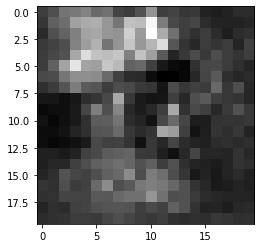

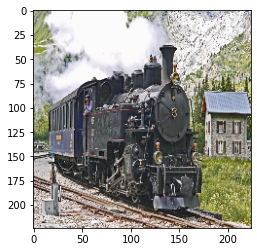

[('n10565667', 'scuba_diver', 0.97817004), ('n04251144', 'snorkel', 0.004101124), ('n03868863', 'oxygen_mask', 0.0030541178), ('n02795169', 'barrel', 0.0027703051), ('n02174001', 'rhinoceros_beetle', 0.0024055014)]


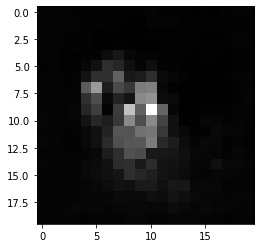

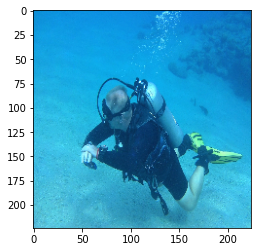

[('n02002556', 'white_stork', 0.80985), ('n02002724', 'black_stork', 0.10066416), ('n02012849', 'crane', 0.08381028), ('n02007558', 'flamingo', 0.0011981854), ('n02006656', 'spoonbill', 0.001015526)]


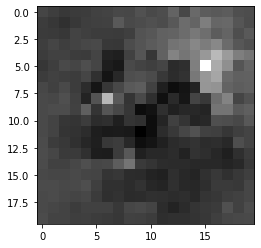

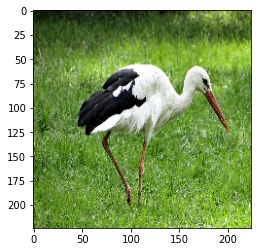

[('n03977966', 'police_van', 0.88456345), ('n02701002', 'ambulance', 0.0937818), ('n03770679', 'minivan', 0.02020305), ('n03769881', 'minibus', 0.001183826), ('n02930766', 'cab', 0.00018289605)]


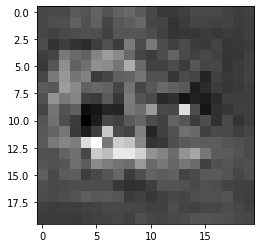

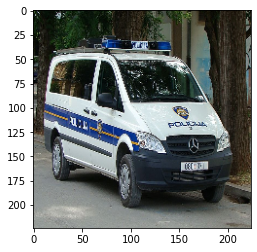

In [ ]:
for test_img in test_imgs:
  hmap = generate_heatmap(test_img, resnet, 20, 9)
  plt.imshow(hmap,cmap='gray')
  plt.show()
  plt.imshow(test_img[:,:,::-1])
  plt.show()